In [1]:
import cvxopt
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets
import sklearn.metrics
import scipy.spatial

Import the dataset files:

In [2]:
X_train, y_train = sklearn.datasets.load_svmlight_file('./dataset/satimage.scale.tr')
X_val, y_val = sklearn.datasets.load_svmlight_file('./dataset/satimage.scale.val')
X_test, y_test = sklearn.datasets.load_svmlight_file('./dataset/satimage.scale.t')

Convert sparse matrices to numpy arrays:

In [3]:
X_train = np.asarray(X_train.todense())
X_val = np.asarray(X_val.todense())
X_test = np.asarray(X_test.todense())

Only keep data points that belong to class 4 or 6:

In [4]:
def filter_dataset(X, y, labels, new_labels=None):
    X_new = X[np.in1d(y, labels)]
    y_new = y[np.in1d(y, labels)]
    if new_labels:
        for old, new in zip(labels, new_labels):
            y_new[y_new == old] = new
    return X_new, y_new


X_train, y_train = filter_dataset(
    X_train, y_train, labels=(4, 6), new_labels=(-1, 1))
X_val, y_val = filter_dataset(
    X_val, y_val, labels=(4, 6), new_labels=(-1, 1))
X_test, y_test = filter_dataset(
    X_test, y_test, labels=(4, 6), new_labels=(-1, 1))

<br>

# 1. Soft Margin SVM

In [5]:
class SoftSVM:
    def __init__(self, C):
        self._C = C
        self._w = None
        self._b = None

    def fit(self, X_train, y_train):
        n = X_train.shape[0]

        K = (y_train.reshape(-1, 1) * X_train)
        coeffs = K @ K.T

        P = cvxopt.matrix(coeffs)
        q = cvxopt.matrix(-1 * np.ones(n))
        G = cvxopt.matrix(
            np.concatenate((-1 * np.identity(n), np.identity(n)), axis=0))
        h = cvxopt.matrix(
            np.concatenate((-1 * np.zeros(n), self._C * np.ones(n)), axis=0))
        A = cvxopt.matrix(1.0 * y_train, (1, n))
        b = cvxopt.matrix(0.0)

        cvxopt.solvers.options['show_progress'] = False
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
        alpha = np.ravel(solution['x']).reshape(-1, 1)

        S = np.where((alpha > 1e-10) & (alpha <= self._C))[0]
        self._w = K.T[:, S] @ alpha[S]

        M = np.where((alpha > 1e-10) & (alpha < self._C))[0]
        self._b = np.mean(y_train[M] - X_train[M, :] @ self._w)

    def predict(self, X):
        y_pred = np.sign(X @ self._w + self._b)
        y_pred[y_pred == 0] = 1
        return y_pred.squeeze()



Instantiate the model and train it on training data:

In [6]:
model = SoftSVM(C=1)
model.fit(X_train, y_train)

### 1.1. Performance on Test Data
Express model's performance in terms of confusion matrix and balanced accuracy using test data:

Accuracy on test data          = 0.818
Balanced accuracy on test data = 0.825


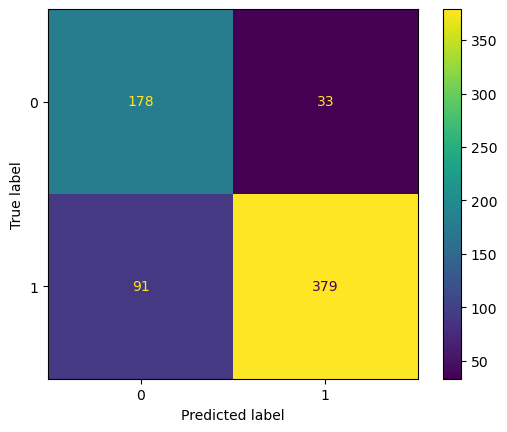

In [7]:
y_pred = model.predict(X_test)

acc = sklearn.metrics.accuracy_score(y_test, y_pred)
bacc = sklearn.metrics.balanced_accuracy_score(y_test, y_pred)
print(f'Accuracy on test data          = {acc:.3f}')
print(f'Balanced accuracy on test data = {bacc:.3f}')

cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

<br>

# 2. Soft Margin SVM with RBF Kernel

In [8]:
class SoftSVM_RBF:
    def __init__(self, C, sigma):
        self._C = C
        self._sigma = sigma
        self._b = None
        self.sv_x = None
        self.sv_y = None
        self.sv_alpha = None

    def _rbf(self, X, Y):
        return np.exp(-(scipy.spatial.distance_matrix(X, Y) ** 2) / (2 * self._sigma ** 2))

    def fit(self, X_train, y_train):
        n = X_train.shape[0]

        coeffs = np.outer(y_train, y_train) * self._rbf(X_train, X_train)

        P = cvxopt.matrix(coeffs)
        q = cvxopt.matrix(-1 * np.ones(n))
        G = cvxopt.matrix(
            np.concatenate((-1 * np.identity(n), np.identity(n)), axis=0))
        h = cvxopt.matrix(
            np.concatenate((-1 * np.zeros(n), self._C * np.ones(n)), axis=0))
        A = cvxopt.matrix(1.0 * y_train, (1, n))
        b = cvxopt.matrix(0.0)

        cvxopt.solvers.options['show_progress'] = False
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        alpha = np.ravel(solution['x']).reshape(-1, 1)

        S = np.where((alpha > 1e-10) & (alpha <= self._C))[0]
        self.sv_x = X_train[S, :]
        self.sv_y = y_train[S].reshape(-1, 1)
        self.sv_alpha = alpha[S]

        M = np.where((alpha > 1e-10) & (alpha < self._C))[0]
        first_margin_sv_x = X_train[M, :][0].reshape(1, -1)
        first_margin_sv_y = y_train[M][0]

        self._b = first_margin_sv_y - \
            (self._rbf(self.sv_x, first_margin_sv_x).T @
             (self.sv_y * self.sv_alpha)).squeeze()

    def predict(self, X):
        return np.sign((self._rbf(X, self.sv_x) @ (self.sv_y * self.sv_alpha)).squeeze())

### 2.1. Choosing Hyperparameter "σ"
Instantiate the model and train it on training data. Use validation data to fine-tune the hyperparameter "σ":

In [9]:
def compare_models(models, title, xlabel, ylabel, discrete=False):
    x_axis = list(models.keys())
    y_axis = [v[1] for v in models.values()]
    if discrete:
        plt.bar(x_axis, y_axis)
        plt.ylim(min(y_axis) - 0.03, max(y_axis) + 0.03)
    else:
        plt.plot(x_axis, y_axis)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

Best value for hyperparameter σ = 0.500
Best accuracy on validation set = 0.911


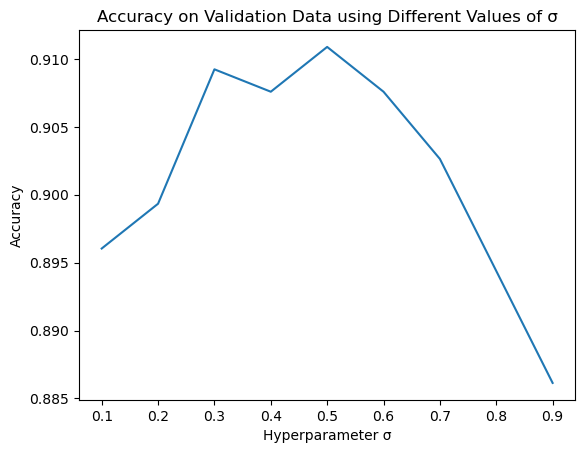

In [10]:
models = {}
for sigma in np.arange(0.1, 1, 0.1):
    model = SoftSVM_RBF(C=1, sigma=sigma)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    acc = sklearn.metrics.accuracy_score(y_val, y_pred)
    models[sigma] = (model, acc)

best_sigma, (best_model, best_acc) = max(models.items(), key=lambda v: v[1][1])
print(f'Best value for hyperparameter σ = {best_sigma:.3f}')
print(f'Best accuracy on validation set = {best_acc:.3f}')

compare_models(models, xlabel='Hyperparameter σ', ylabel='Accuracy',
               title='Accuracy on Validation Data using Different Values of σ')

### 2.2. Performance on Test Data
Express best model's performance in terms of confusion matrix and balanced accuracy using test data:

Accuracy on test data          = 0.871
Balanced accuracy on test data = 0.874


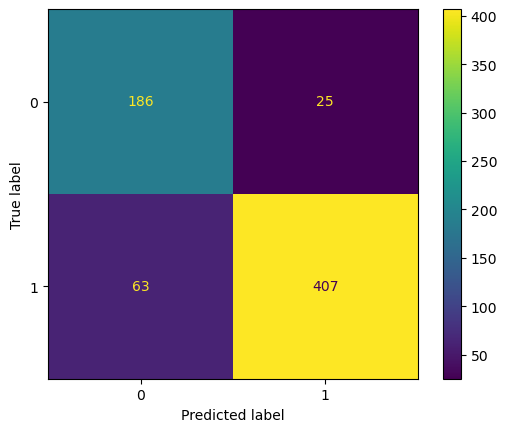

In [11]:
y_pred = best_model.predict(X_test)

acc = sklearn.metrics.accuracy_score(y_test, y_pred)
bacc = sklearn.metrics.balanced_accuracy_score(y_test, y_pred)
print(f'Accuracy on test data          = {acc:.3f}')
print(f'Balanced accuracy on test data = {bacc:.3f}')

cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

<br>

# 3. Scikit-Learn's Implementation of SVM

In [12]:
import sklearn.svm

Import the dataset files:

In [13]:
X_train, y_train = sklearn.datasets.load_svmlight_file('./dataset/satimage.scale.tr')
X_val, y_val = sklearn.datasets.load_svmlight_file('./dataset/satimage.scale.val')
X_test, y_test = sklearn.datasets.load_svmlight_file('./dataset/satimage.scale.t')

### 3.1. Choosing the Kernel

Best kernel                     = rbf
Best accuracy on validation set = 0.863


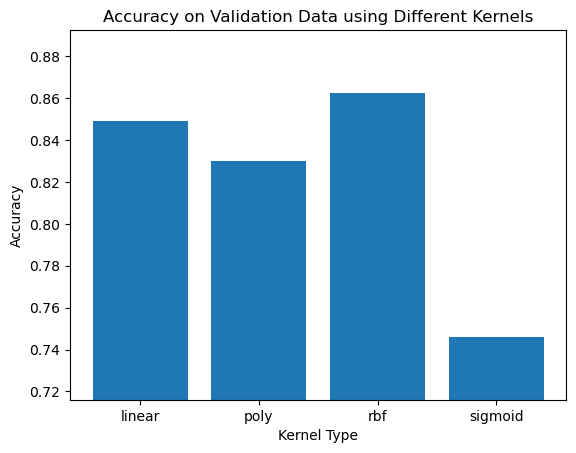

In [14]:
models = {}
for kernel in ('linear', 'poly', 'rbf', 'sigmoid'):
    model = sklearn.svm.SVC(kernel=kernel)
    model = model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    acc = sklearn.metrics.accuracy_score(y_val, y_pred)
    models[kernel] = (model, acc)

best_kernel, (best_model, best_acc) = max(
    models.items(), key=lambda v: v[1][1])
print(f'Best kernel                     = {best_kernel}')
print(f'Best accuracy on validation set = {best_acc:.3f}')

compare_models(models, xlabel='Kernel Type', ylabel='Accuracy',
               title='Accuracy on Validation Data using Different Kernels',
               discrete=True)

According to the above results, <b><i>RBF kernel</i></b> is chosen.

### 3.2. Choosing Hyperparamter "C"

Best value for hyperparameter C = 16.000
Best accuracy on validation set = 0.887


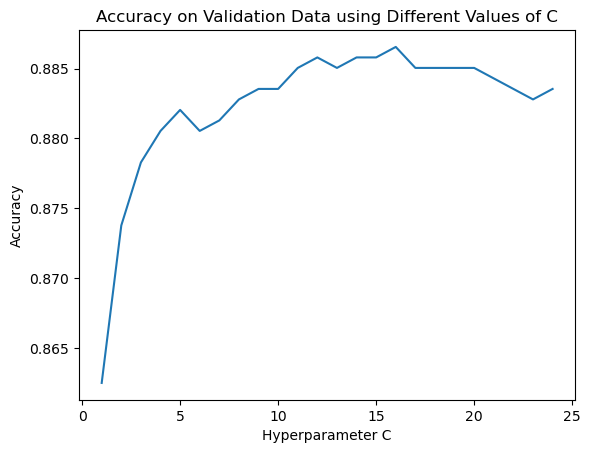

In [15]:
models = {}
for C in np.arange(1, 25, 1):
    model = sklearn.svm.SVC(C=C, kernel='rbf')
    model = model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    acc = sklearn.metrics.accuracy_score(y_val, y_pred)
    models[C] = (model, acc)

best_C, (best_model, best_acc) = max(models.items(), key=lambda v: v[1][1])
print(f'Best value for hyperparameter C = {best_C:.3f}')
print(f'Best accuracy on validation set = {best_acc:.3f}')

compare_models(models, xlabel='Hyperparameter C', ylabel='Accuracy',
               title='Accuracy on Validation Data using Different Values of C')

According to the above results, <b><i>C=16</i></b> is chosen.

### 3.3. Choosing Hyperparamter "γ"

Best value for hyperparameter γ = scale
Best accuracy on validation set = 0.887


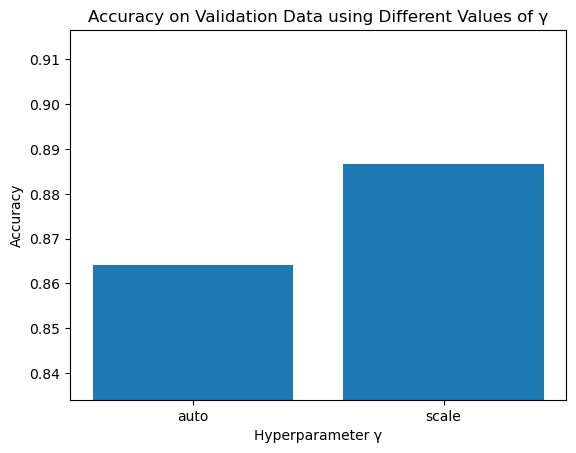

In [16]:
models = {}
for gamma in ('auto', 'scale'):
    model = sklearn.svm.SVC(C=16, kernel='rbf', gamma=gamma)
    model = model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    acc = sklearn.metrics.accuracy_score(y_val, y_pred)
    models[gamma] = (model, acc)

best_gamma, (best_model, best_acc) = max(models.items(), key=lambda v: v[1][1])
print(f'Best value for hyperparameter γ = {best_gamma}')
print(f'Best accuracy on validation set = {best_acc:.3f}')

compare_models(models, xlabel='Hyperparameter γ', ylabel='Accuracy',
               title='Accuracy on Validation Data using Different Values of γ',
               discrete=True)

According to the above results, <b><i>γ="scale"</i></b> is chosen.

### 3.4. Performance on Test Data
Express best model's performance in terms of confusion matrix and balanced accuracy using test data:

Accuracy on test data          = 0.895
Balanced accuracy on test data = 0.878


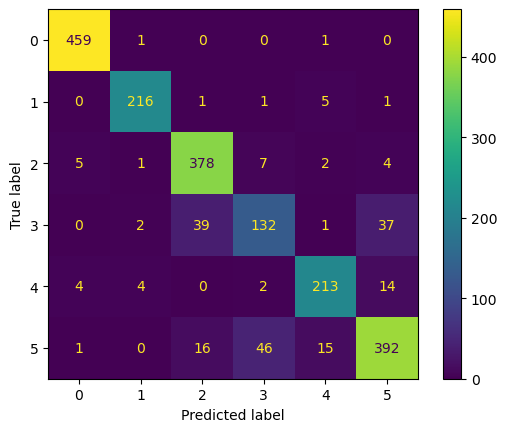

In [17]:
y_pred = best_model.predict(X_test)

acc = sklearn.metrics.accuracy_score(y_test, y_pred)
bacc = sklearn.metrics.balanced_accuracy_score(y_test, y_pred)
print(f'Accuracy on test data          = {acc:.3f}')
print(f'Balanced accuracy on test data = {bacc:.3f}')

cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

<br>

# 4. Multiclass Soft Margin SVM

Only keep data points that belong to class 4, 5, or 6:

In [18]:
X_train = np.asarray(X_train.todense())
X_val = np.asarray(X_val.todense())
X_test = np.asarray(X_test.todense())

X_train, y_train = filter_dataset(
    X_train, y_train, labels=(4, 5, 6), new_labels=(1, 2, 3))
X_val, y_val = filter_dataset(
    X_val, y_val, labels=(4, 5, 6), new_labels=(1, 2, 3))
X_test, y_test = filter_dataset(
    X_test, y_test, labels=(4, 5, 6), new_labels=(1, 2, 3))

In [19]:
class SoftSVM_RBF_3Class:
    def __init__(self, C, sigma):
        self.models = {
            (1, 2): SoftSVM_RBF(C, sigma),
            (1, 3): SoftSVM_RBF(C, sigma),
            (2, 3): SoftSVM_RBF(C, sigma),
        }

    def fit(self, X_train, y_train):
        for classes in ((1, 2), (1, 3), (2, 3)):
            X, y = filter_dataset(
                X_train, y_train, labels=classes, new_labels=(-1, 1))
            self.models[classes].fit(X, y)

    def predict(self, X):
        y_preds = []
        for classes in ((1, 2), (1, 3), (2, 3)):
            y_pred = self.models[classes].predict(X)
            y_pred = self._change_labels(
                y_pred, old_labels=reversed((-1, 1)),
                new_labels=reversed(classes))
            y_preds.append(y_pred)
        return self._majority(y_preds)

    def _change_labels(self, y, new_labels, old_labels=(1, -1)):
        for old, new in zip(old_labels, new_labels):
            y[y == old] = new
        return y

    def _majority(self, y_preds):
        stacked = np.stack(y_preds, axis=-1)
        stacked = stacked.astype(int)
        return np.apply_along_axis(
            lambda x: np.bincount(x).argmax(), axis=-1, arr=stacked)

### 4.1. Choosing Hyperparameter "σ"
Instantiate the model and train it on training data. Use validation data to fine-tune the hyperparameter "σ":

Best value for hyperparameter σ = 0.300
Best accuracy on validation set = 0.887


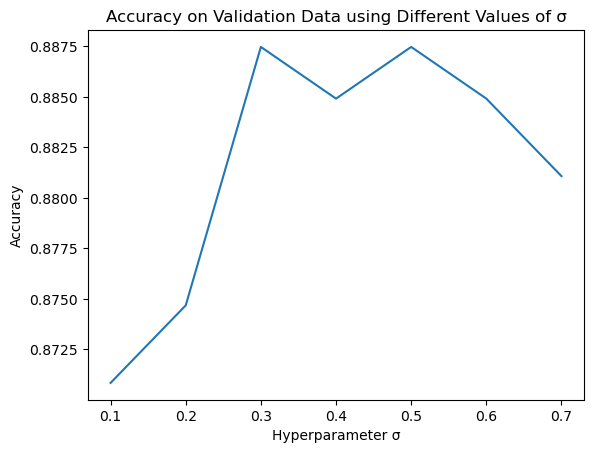

In [20]:
models = {}
for sigma in np.arange(0.1, 0.8, 0.1):
    model = SoftSVM_RBF_3Class(C=1, sigma=sigma)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    acc = sklearn.metrics.accuracy_score(y_val, y_pred)
    models[sigma] = (model, acc)

best_sigma, (best_model, best_acc) = max(models.items(), key=lambda v: v[1][1])
print(f'Best value for hyperparameter σ = {best_sigma:.3f}')
print(f'Best accuracy on validation set = {best_acc:.3f}')

compare_models(models, xlabel='Hyperparameter σ', ylabel='Accuracy',
               title='Accuracy on Validation Data using Different Values of σ')

### 4.2. Performance on Test Data
Express best model's performance in terms of confusion matrix and balanced accuracy using test data:

Accuracy on test data          = 0.879
Balanced accuracy on test data = 0.886


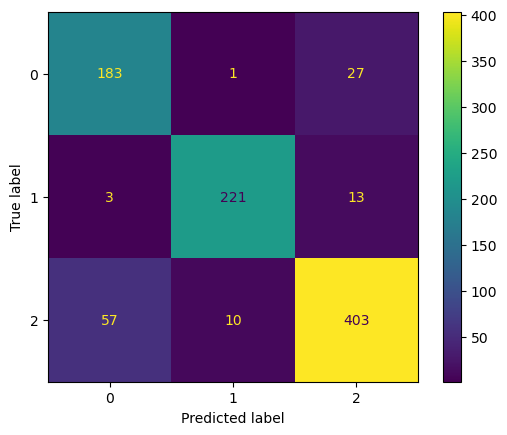

In [21]:
y_pred = best_model.predict(X_test)

acc = sklearn.metrics.accuracy_score(y_test, y_pred)
bacc = sklearn.metrics.balanced_accuracy_score(y_test, y_pred)
print(f'Accuracy on test data          = {acc:.3f}')
print(f'Balanced accuracy on test data = {bacc:.3f}')

cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()